In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from torch import nn 
from torch import optim
import torchvision.transforms as transforms
import torch, torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
import cv2
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split

In [4]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import PAN
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import segmentation_models_pytorch.utils as smp_utils

In [5]:
import warnings
warnings.filterwarnings("ignore")

(720, 1280, 3)


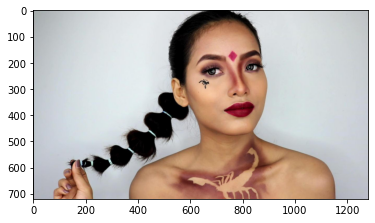

In [6]:
img = plt.imread('720p/image00011995.jpg')
print(img.shape)
plt.imshow(img);

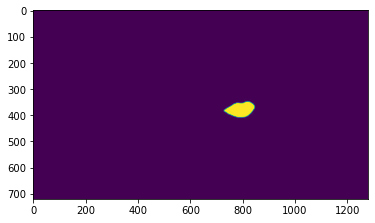

In [7]:
img = plt.imread('mask/mask00011995.png')
plt.imshow(img[..., 1]);

In [8]:
df_images = pd.read_csv('list.csv')
df_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [9]:
df_images = df_images[['filename', 'mask']]
df_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [10]:
list_images = sorted([i for i in Path('720p').iterdir()])
list_masks = sorted([i for i in Path('mask').iterdir()])
len(list_images), len(list_masks)

(28594, 28540)

In [11]:
df_images = df_images.loc[df_images['mask'].isin([i.name for i in list_masks])]
df_images.reset_index(drop=True, inplace=True)
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [12]:
class LipsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        
        self.image_arr = self.data.iloc[:,0]
        self.label_arr = self.data.iloc[:,1]
        

        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
    
        img = cv2.cvtColor(cv2.imread('720p/' + \
              self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        mask = cv2.cvtColor(cv2.imread('mask/' + \
               self.label_arr[index]), cv2.COLOR_BGR2RGB)
        cls_mask = mask[:, :, 1]
        cls_mask = np.where(mask > 10, 1, 0)[:, :, 1]
        cls_mask = cls_mask.astype('float')
        cls_mask = cv2.resize(cls_mask, (256, 256))

        masks = [cls_mask]
            
        masks = torch.as_tensor(masks, dtype=torch.uint8)    
        
            
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [14]:
# Используем модель PAN
BACKBONE = 'resnet50'
segmodel = smp.PAN(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained=\
                                                     'imagenet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


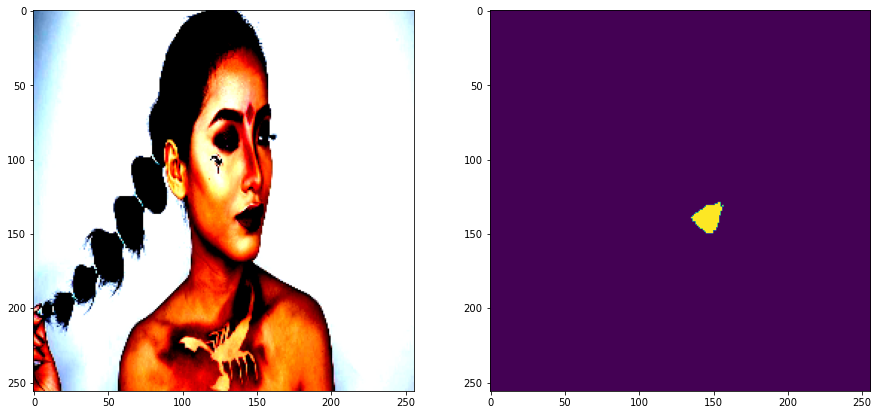

In [15]:
dataset = LipsDataset(df_images, preprocessing=preprocess_input)
img, masks = dataset[11994]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[:, :, 0])
plt.show()

In [16]:
X_train, X_test = train_test_split(df_images, test_size=0.3)

In [17]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [18]:
train_data = LipsDataset(X_train)
test_data = LipsDataset(X_test)

In [19]:
train_data_loader = DataLoader(
    train_data,
    batch_size=16,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=8,
    shuffle=False
)

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])
tensor(0.) tensor(1.)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


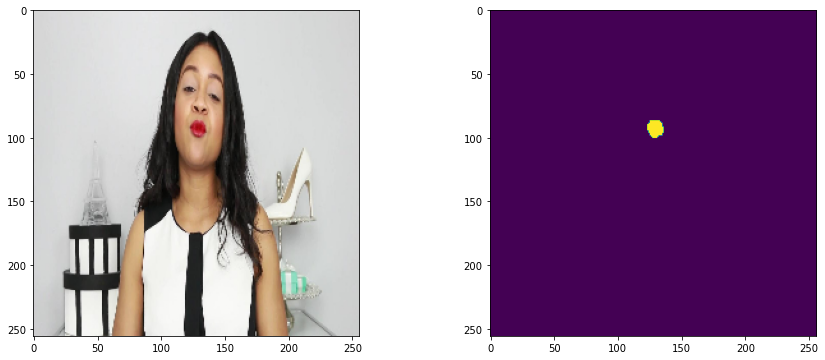

In [20]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

In [21]:
for param in list(segmodel.encoder.parameters())[:]:
    param.requires_grad = False

In [22]:
criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

In [23]:
params_to_update = []
for name, param in segmodel.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

In [24]:
optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [25]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,)
valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,)

In [26]:
max_score = 0
for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)

Epoch: 1
valid: 100%|██████████████████████████████| 1071/1071 [30:37<00:00,  1.72s/it, dice_loss - 0.05909, iou_score - 0.8989]


In [28]:
data_iter = iter(train_data_loader)
images, labels = next(data_iter)

In [29]:
outputs = segmodel(images)

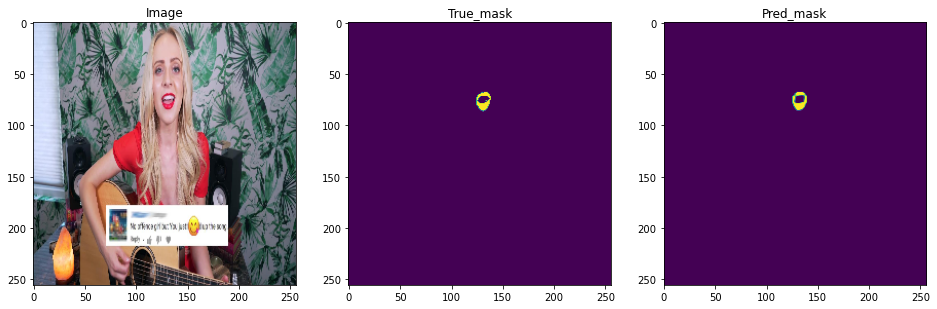

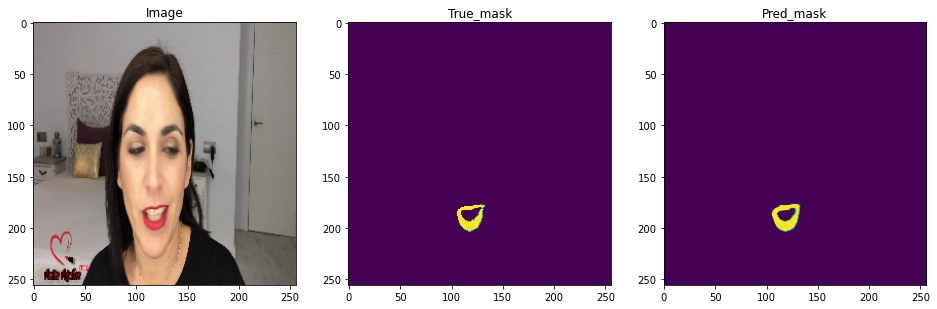

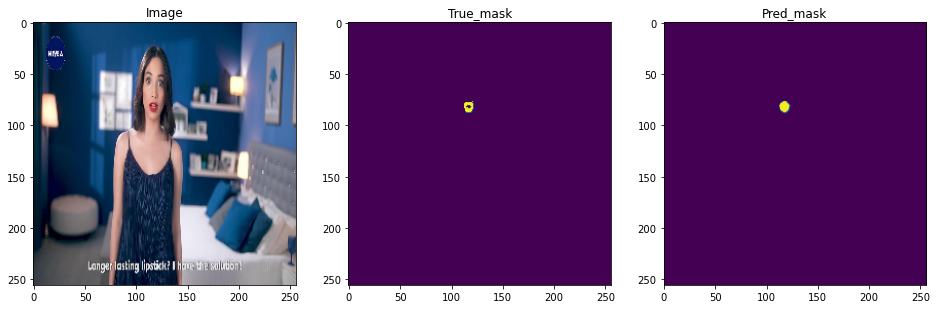

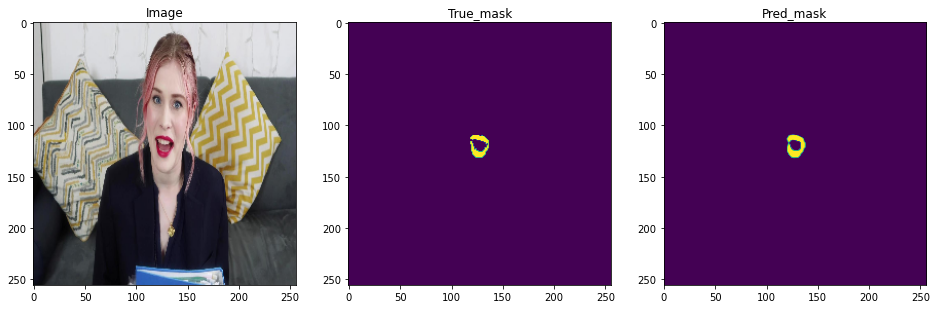

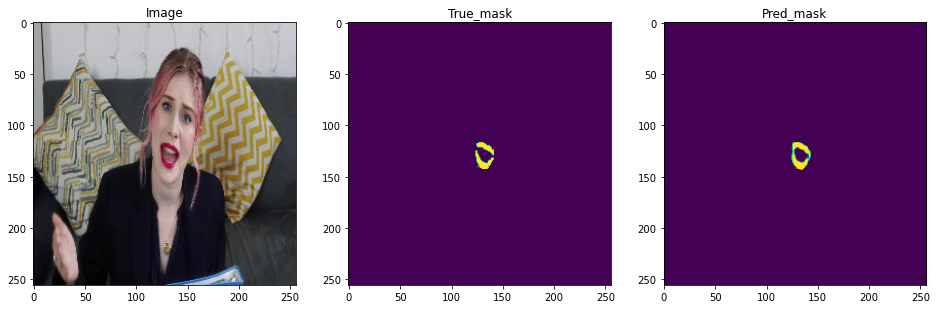

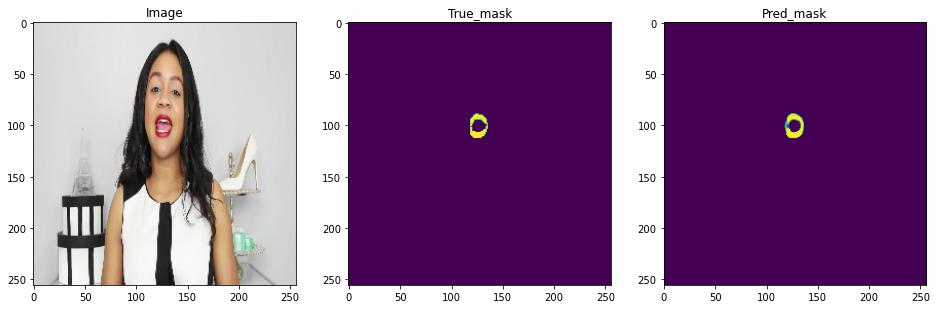

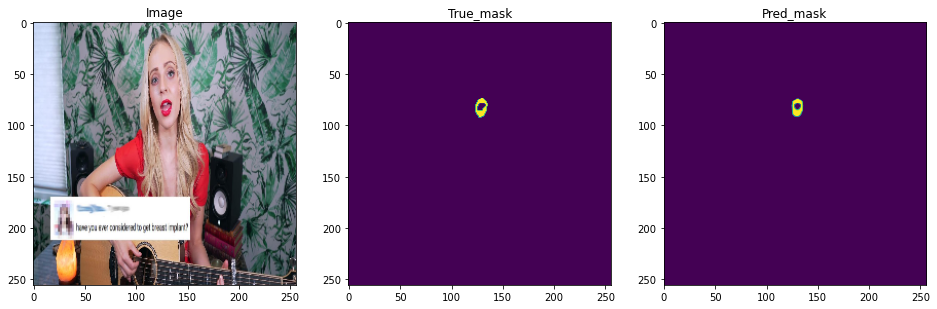

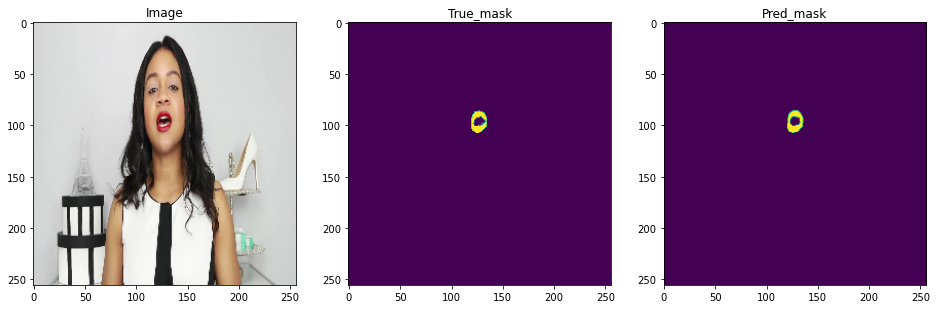

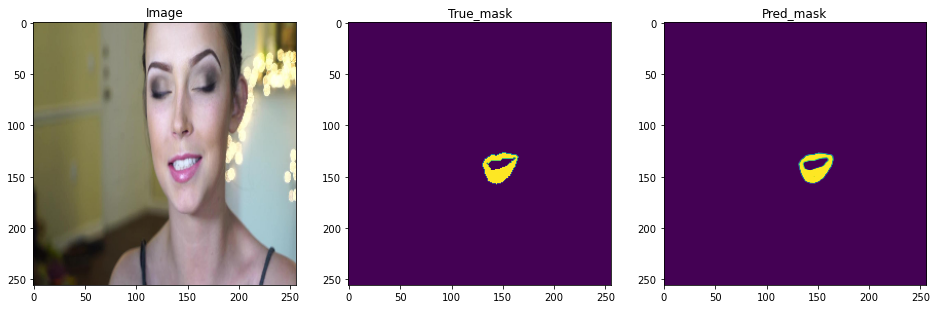

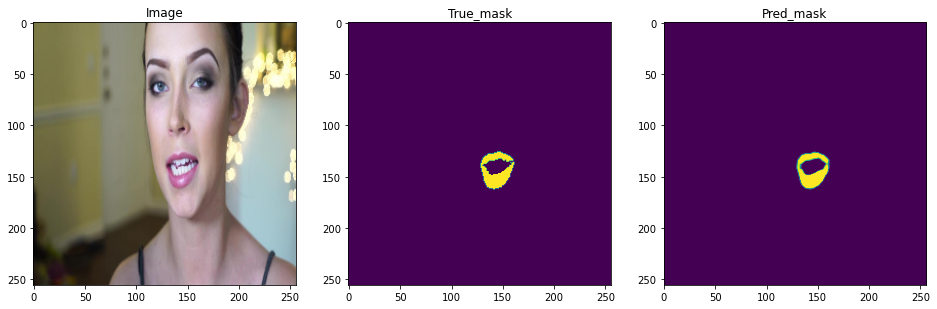

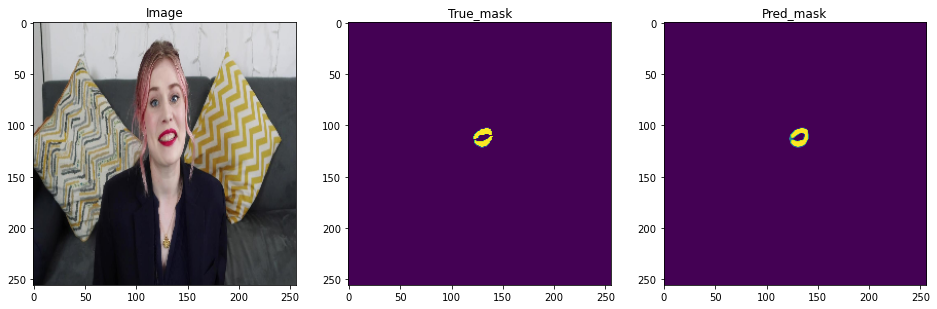

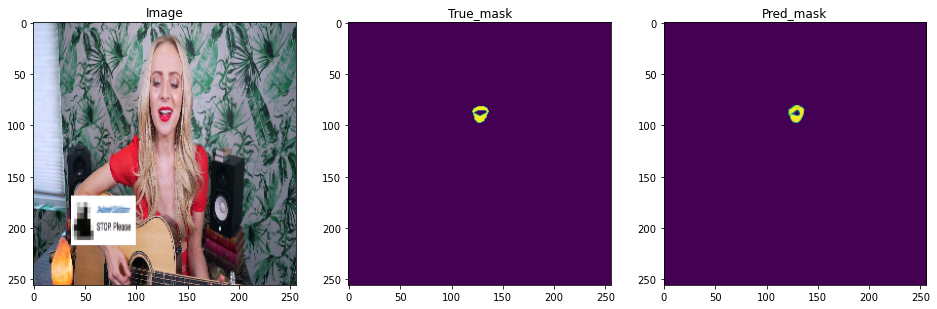

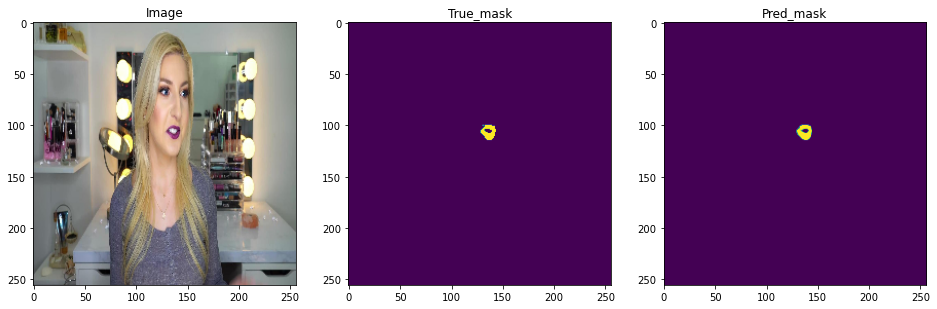

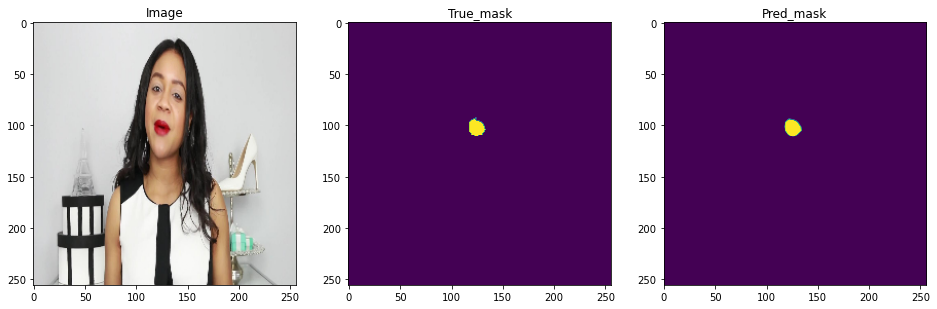

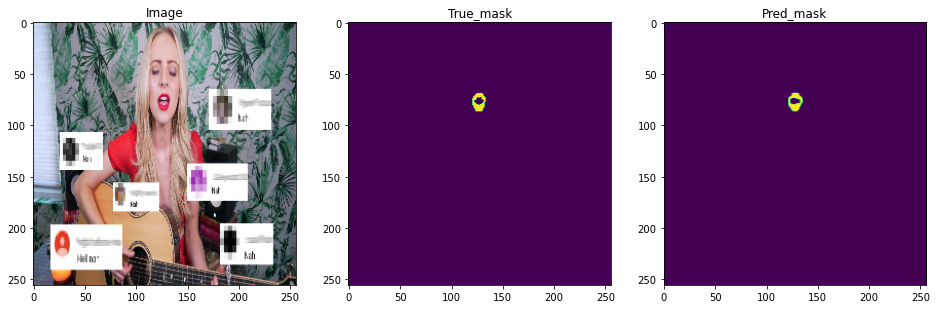

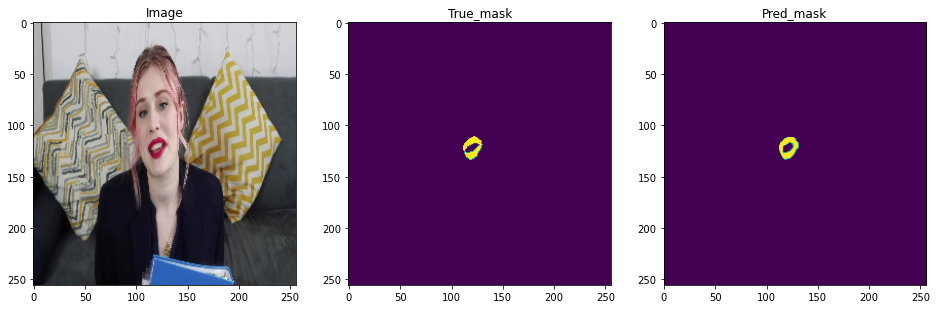

In [30]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0)[:, :, 0])
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0)[:, :, 0])
    ax_3.set_title('Pred_mask')